#### Buoyancy-precip relationship over tropical regions
- reproduce the figure in Schiro et al. 2018 ('BLcounts_criticalval_map_writeout.py')
- checking if the BL, critical is around -5K using ERA5 and GPM-IMERG (previously ERA-Int, TRMM)
- linking this to "MCSinit_highBL_geomap.ipynb"

In [1]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [ ]:
# # set fonts configuration - Arial
# matplotlib.rcParams['font.family'] = "Open Sans"
# matplotlib.rcParams['font.sans-serif'] = "Arial"

In [ ]:
# WPC = [-10,5,130,170]
# IND = [-10,5,70,90]
# EPC = [0,10,240,260]
# ATL = [0,10,320,340]
# WAF = [-10,10,0,30]
# MC = [-7,7,95,125]
# AMZ = [-10,5,285,310]

In [ ]:
# BL_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae')
# data_temp = xr.open_dataset(BL_dir / 'era5_2layers_thetae_2008_06_19.nc').sel(lat=slice(-30,30))
# lon_re = data_temp.lon
# lat_re = data_temp.lat

In [ ]:
# def write_histogram_regions(Buoy_TOT, prec_gpm, bins_bl, geo_info):
#     """
#     write out histogram of BL values by the given bins
#     """
#     buoy_samples = np.zeros(len(bins_bl)-1)
#     prec_gpm_sum = np.copy(buoy_samples)
    
#     Buoy_sub = Buoy_TOT.sel(lat=slice(geo_info[0],geo_info[1])
#                                 , lon=slice(geo_info[2],geo_info[3]))
#     prec_sub = prec_gpm.sel(lat=slice(geo_info[0],geo_info[1])
#                                 , lon=slice(geo_info[2],geo_info[3]))
#     prec_sub = prec_sub[['time','lat','lon']]
    
#     # get 1-D BL values over the specified region
#     BL_1d = Buoy_sub.values.ravel()
#     prec_gpm_1d = prec_sub.values.transpose().ravel() # transpose to match BL_1d (lat,lon)

#     for n in range(len(bins_bl)-1):
#         idx = np.where(np.logical_and(BL_1d >= bins_bl[n], BL_1d < bins_bl[n+1]))[0]
#         buoy_samples[n] = len(idx)
#         prec_gpm_sum[n] = np.sum(prec_gpm_1d[idx])
    
#     return (buoy_samples, prec_gpm_sum)

In [ ]:
# %%time
# bins_bl = np.arange(-30,10,0.2) # degree Kelvin
# buoy_samples = np.zeros((7,len(bins_bl)-1)) # 7 tropical regions
# prec_gpm_sum = np.copy(buoy_samples)

# year_list = np.arange(2002,2015)

# for year in year_list[:1]:

#     print('processing year: {}'.format(year))
#     buoy_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae/')
#     era5_dir = Path('/neelin2020/ERA-5/NC_FILES/{}'.format(year))
#     gpm_dir = Path('/neelin2020/RGMA_feature_mask/GPM_ncfiles_{}'.format(year))

#     for month in np.arange(1,2):
#         print('month: {}'.format(str(month).zfill(2)))

#         # 1. 0.25-deg, 3-hourly buoyancy measure: BL = BL,cape - BL,subsat
#         buoy_files = list(buoy_dir.glob('era5_2layers_thetae_{}_{}_*.nc'.format(year,str(month).zfill(2))))
#         data_buoy = xr.open_mfdataset(buoy_files).sel(lat=slice(-30,30))

#         data_sp = xr.open_dataset(era5_dir / 'era-5.sp.{}.{}.nc'.format(year,str(month).zfill(2))).sel(latitude=slice(30,-30)).SP/100 # hPa
#         data_sp = data_sp.reindex(latitude=sorted(list(data_sp.latitude))) # fliping latitude order: -30 to 30
#         data_sp = data_sp.interp(latitude=lat_re.values, longitude=lon_re.values)
#         data_sp = data_sp.rename({'latitude': 'lat', 'longitude': 'lon'})
#         sp = data_sp.sel(time=data_buoy.time)

#         thetae_bl = data_buoy.thetae_bl
#         thetae_sat_lt = data_buoy.thetae_sat_lt
#         thetae_lt = data_buoy.thetae_lt

#         delta_pl=sp-100-500 # top at 500hPa
#         delta_pb=100
#         wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
#         wl=1-wb

#         Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
#         Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340
#         Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT # degree Kelvin (K)

#         # 2. 0.25-deg, 3-hrly GPM-IMERG, calibrated
#         gpm_files = list(gpm_dir.glob('GPM_IMERGE_V06_{}{}*.nc'.format(year,str(month).zfill(2))))
#         data_gpm = xr.open_mfdataset(gpm_files).sel(lat=slice(-30,30))
#         data_gpm['lon'] = data_gpm.lon.where(data_gpm.lon > 0, data_gpm.lon + 360)
#         data_gpm = data_gpm.reindex(lon = sorted(data_gpm.lon))
#         data_gpm = data_gpm.interp(lon = lon_re, lat = lat_re)   
#         prec_gpm = data_gpm.precipitationCal.sel(time=data_buoy.time)

#         # 3. sampling by BL bins over regions
#         # WPC = [lat_s, lat_n, lon_s, lon_n]
#         for n, geo_info in enumerate([WPC, EPC, ATL, WAF, MC, AMZ]):
#             (b_samples, gpm_sum) = write_histogram_regions(Buoy_TOT
#                                                          , prec_gpm, bins_bl, geo_info)

#             buoy_samples[n,:] += b_samples
#             prec_gpm_sum[n,:] += gpm_sum

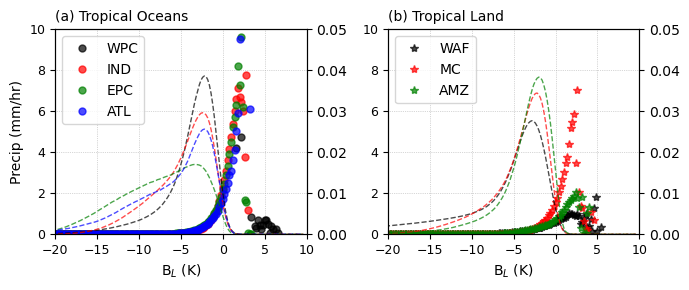

In [19]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats')
data = xr.open_dataset(out_dir / 'buoy_precipitation_multiregions.nc')

markers = ['o','o','o','o','*','*','*']
colors = ['k','r','g','b','y','m','skyblue']

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7,3))

ax_s1 = ax1.twinx()
for n,region in enumerate(data.region.values[:4]):
    samples = data.samples.sel(region=region)
    prec_sum = data.prec_gpm_sum.sel(region=region)
    cond_prec = prec_sum/samples

    ax1.plot(data.BL_bins, cond_prec, color=colors[n], ls='None', ms=5, marker='o', label=region,
            alpha=0.7)
    ax_s1.plot(data.BL_bins, samples/samples.sum(), color=colors[n], lw=1, ls='--', alpha=0.7)
    
ax1.set_ylabel('Precip (mm/hr)',fontsize=10)
ax1.set_xlabel('B$_{L}$ (K)',fontsize=10)
ax1.tick_params(labelsize=9)
ax1.set_ylim([0,10])
ax1.set_xlim([-20,10])
ax1.legend(loc=2)
ax1.grid(lw=0.5,ls=':')
ax_s1.set_ylim([0,0.05])

ax_s2 = ax2.twinx()
for n,region in enumerate(data.region.values[-3:]):
    samples = data.samples.sel(region=region)
    prec_sum = data.prec_gpm_sum.sel(region=region)
    cond_prec = prec_sum/samples

    ax2.plot(data.BL_bins, cond_prec, color=colors[n], ls='None', ms=6, marker='*', label=region,
            alpha=0.7)
    ax_s2.plot(data.BL_bins, samples/samples.sum(), color=colors[n], lw=1, ls='--', alpha=0.7)
    
#ax2.set_ylabel('Precip (mm/hr)',fontsize=10)
ax2.set_xlabel('B$_{L}$ (K)',fontsize=10)
ax2.tick_params(labelsize=9)
ax2.set_ylim([0,10])
ax2.set_xlim([-20,10])
ax2.legend(loc=2)
ax2.grid(lw=0.5,ls=':')
ax_s2.set_ylim([0,0.05])

ax1.set_title('(a) Tropical Oceans', fontsize=10, loc='left')
ax2.set_title('(b) Tropical Land', fontsize=10, loc='left');

plt.tight_layout()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/buoy_precip_relation_multiregions.pdf',
         bbox_inches='tight', transparent=False)

In [7]:
test = xr.open_dataset('/neelin2020/ERA-5_buoy/layer_thetae/era5_2layers_thetae_2008_06_25.nc')

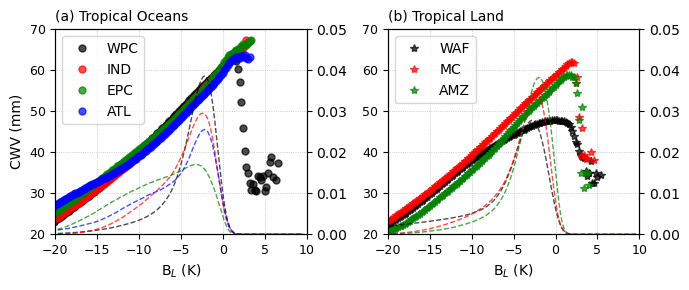

In [17]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats')
data = xr.open_dataset(out_dir / 'buoy_cwv_multiregions.nc')

markers = ['o','o','o','o','*','*','*']
colors = ['k','r','g','b','y','m','skyblue']

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7,3))

ax_s1 = ax1.twinx()
for n,region in enumerate(data.region.values[:4]):
    samples = data.samples.sel(region=region)
    prec_sum = data.cwv_sum.sel(region=region)
    cond_prec = prec_sum/samples

    ax1.plot(data.BL_bins, cond_prec, color=colors[n], ls='None', ms=5, marker='o', label=region,
            alpha=0.7)
    ax_s1.plot(data.BL_bins, samples/samples.sum(), color=colors[n], lw=1, ls='--', alpha=0.7)
    
ax1.set_ylabel('CWV (mm)',fontsize=10)
ax1.set_xlabel('B$_{L}$ (K)',fontsize=10)
ax1.tick_params(labelsize=9)
ax1.set_ylim([20,70])
ax1.set_xlim([-20,10])
ax1.legend(loc=2)
ax1.grid(lw=0.5,ls=':')
ax_s1.set_ylim([0,0.05])

ax_s2 = ax2.twinx()
for n,region in enumerate(data.region.values[-3:]):
    samples = data.samples.sel(region=region)
    prec_sum = data.cwv_sum.sel(region=region)
    cond_prec = prec_sum/samples

    ax2.plot(data.BL_bins, cond_prec, color=colors[n], ls='None', ms=6, marker='*', label=region,
            alpha=0.7)
    ax_s2.plot(data.BL_bins, samples/samples.sum(), color=colors[n], lw=1, ls='--', alpha=0.7)
    
#ax2.set_ylabel('Precip (mm/hr)',fontsize=10)
ax2.set_xlabel('B$_{L}$ (K)',fontsize=10)
ax2.tick_params(labelsize=9)
ax2.set_ylim([20,70])
ax2.set_xlim([-20,10])
ax2.legend(loc=2)
ax2.grid(lw=0.5,ls=':')
ax_s2.set_ylim([0,0.05])

ax1.set_title('(a) Tropical Oceans', fontsize=10, loc='left')
ax2.set_title('(b) Tropical Land', fontsize=10, loc='left');

plt.tight_layout()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/buoy_cwv_relation_multiregions.pdf',
        bbox_inches='tight', transparent=False)